In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from information_scores import *

import sys

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 16]

In [36]:
# Layout the lynx and hare data

time = np.arange(0,1905-1845,2) # original time 

hare = (np.array([20,20,52,83,64,68,83,12,3,150,110,
                  60,7,10,70,100,92,70,10,11,137,137,
                  18,22,52,83,18,10,9,65])) # original hare population values


lynx = (np.array([32,50,12,10,13,36,15,12,6,6,65,70,
                  40,9,20,34,45,40,15,15,60,80,26,18,
                  37,50,35,12,12,25])) # original lynx population values

time_new = np.linspace(0,1903-1845,500) # new time value
dt = np.abs(time_new[1]-time_new[2]) # the new time step

f_hare = interp1d(time,hare,'cubic') # hare inteprolation function

hare_interp = f_hare(time_new) # inteprolated hare population values

f_lynx = interp1d(time,lynx,'cubic') # lynx interpolation function

lynx_interp = f_lynx(time_new) # interpolated lynx population values

X = np.vstack([hare_interp,lynx_interp]) # data matrix

# create the X and Xprime matrices to pass to the SINDy function

# Fourth Order Central Difference
X1 = X[0,:]
X2 = X[1,:]

dX1 = (1/(12*dt)) * (-X1[4:] + 8*X1[3:-1] - 8*X1[1:-3] + X1[:-4])
X1 = X1[2:-2]

dX2 = (1/(12*dt)) * (-X2[4:] + 8*X2[3:-1] - 8*X2[1:-3] + X2[:-4])
X2 = X2[2:-2]

dX = np.vstack([dX1,dX2]) # data matrix

# Trim first and last two that are lost in derivative
X = X[:,2:-2].T
Xprime = dX.T


print(X.shape,Xprime.shape) # print out the shapes of the data matrices as a sanity check

(496, 2) (496, 2)


In [37]:
# SINDy Function Definitions

def build_library(X):
    
    n = X.shape[0]
    Theta = np.zeros((n,1))
    
    # first order polynomial in x (first state)
    first_state = X[:,0]
    Theta[:,0] = first_state
    
    # first order polynomial in y (second state)
    second_state = np.array([X[:,1]]).T
    Theta = np.append(Theta,second_state,axis=1)
    
    # first order polynomial in xy (product of states)
    product = np.array([X[:,0]*X[:,1]]).T
    Theta = np.append(Theta,product,axis = 1)
    
    # second order polynomial in x
    x2 = np.array([X[:,0]*X[:,0]]).T
    Theta = np.append(Theta,x2,axis = 1)
    
    # second order polynomial in y
    y2 = np.array([X[:,1]*X[:,1]]).T
    Theta = np.append(Theta,y2,axis = 1)
    
    # second order polynomial in xy
    xy2 = np.array([(X[:,0]*X[:,1])**2]).T
    Theta = np.append(Theta,xy2,axis = 1)
    
    period1 = 5 
    # sin(omega*x), omega = (2*pi)/T , T = 5 years
    sinx = np.array([np.sin(2*np.pi*X[:,0]/period1)]).T
    Theta = np.append(Theta,sinx,axis = 1)
    
    # sin(omega*y), omega = (2*pi)/T , T = 5 years
    siny = np.array([np.sin(2*np.pi*X[:,1]/period1)]).T
    Theta = np.append(Theta,siny,axis = 1)
    
    # sin(omega*xy), omega = (2*pi)/T , T = 5 years
    sinxy = np.array([np.sin(2*np.pi*(X[:,1]*X[:,0])/period1)]).T
    Theta = np.append(Theta,sinxy,axis = 1)
    
    period2 = 15
    # sin(omega*x), omega = (2*pi)/T , T = 15 years
    sinx2 = np.array([np.sin(2*np.pi*X[:,0]/period2)]).T
    Theta = np.append(Theta,sinx2,axis = 1)
    
    # sin(omega*y), omega = (2*pi)/T , T = 15 years
    siny2 = np.array([np.sin(2*np.pi*X[:,1]/period2)]).T
    Theta = np.append(Theta,siny2,axis = 1)
    
    # sin(omega*xy), omega = (2*pi)/T , T = 15 years
    sinxy2 = np.array([np.sin(2*np.pi*(X[:,1]*X[:,0])/period2)]).T
    Theta = np.append(Theta,sinxy2,axis = 1)
    
 
    return Theta

def Sparse_Regression(Theta,dXdt,thresh):
    
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    smallinds = np.where(np.abs(Xi) < thresh) # find where the entries is Xi are below the threshold
    Xi[smallinds] = 0 # sparsify!!!!! Hell yeah!!!
    
    return Xi

In [56]:
Theta = build_library(X) # build the lbrary of functions (Theta)
threshold = 0.01# thresholding paramater for sparsification
Xi = Sparse_Regression(Theta,Xprime,threshold) # obtain Xi ("ksi") that gives us the coefficients

print(Xi) #rint out Xi as a sanity check

[[ 0.47064556 -0.15382964]
 [ 0.07136272 -0.1406684 ]
 [-0.01110213  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 1.1774889   0.70247632]
 [-2.26756052  0.38733458]
 [-1.10057307  0.45029844]
 [-0.20397052  1.25269343]
 [ 6.53842294 -0.8840448 ]
 [ 0.40342697 -0.33816922]]


In [51]:
# run the best fit model

def Lotka_Volterra(X,t):
    
    x = X[0]
    y = X[1]
    omega1 = 2*np.pi/5
    omega2 = 2*np.pi/15

#     val= np.array([x,y, x*y,x**2,y**2,  x**2*y**2, np.sin(omega1*x), np.sin(omega1*y),np.sin(omega1*x*y),np.sin(omega2*x), np.sin(omega2*y),np.sin(omega2*x*y)])
#     #print(Xi.T.shape)
#     #print(val.shape)
#     x_dot= Xi.T@val
#     print(x_dot.shape)
#    sys.exit()
    xdot = (0.47064556*x+0.07136272*y-0.01110213*x*y-0.00118093*x**2-0.0050453*y**2+6.53842294*np.sin(omega2*y)
             +1.1774889*np.sin(omega1*x)-2.26756052*np.sin(omega1*y)-1.10057307e+00*np.sin(omega1*x*y)-2.03970520e-01*np.sin(omega2*x)+4.03426966e-01*np.sin(omega2*y))

    
    ydot = (-0.15382964*x - 0.1406684*y+5.63696948e-03*x*y+0.00179203*x**2-0.00275862*y**2+
            1.25269343*np.sin(omega2*x))

    return [xdot,ydot]

P0 = [20, 32]
Ps = odeint(Lotka_Volterra, P0, time_new)
hare_pop = Ps[:,0]
lynx_pop = Ps[:,1]

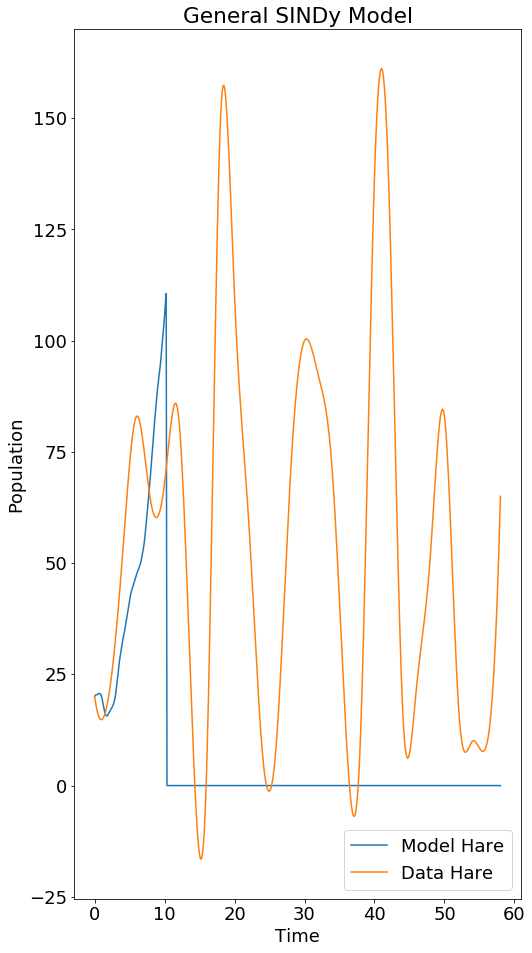

In [52]:
plt.plot(time_new, hare_pop, label="Model Hare")
plt.plot(time_new, hare_interp, label="Data Hare")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("General SINDy Model")
plt.legend()

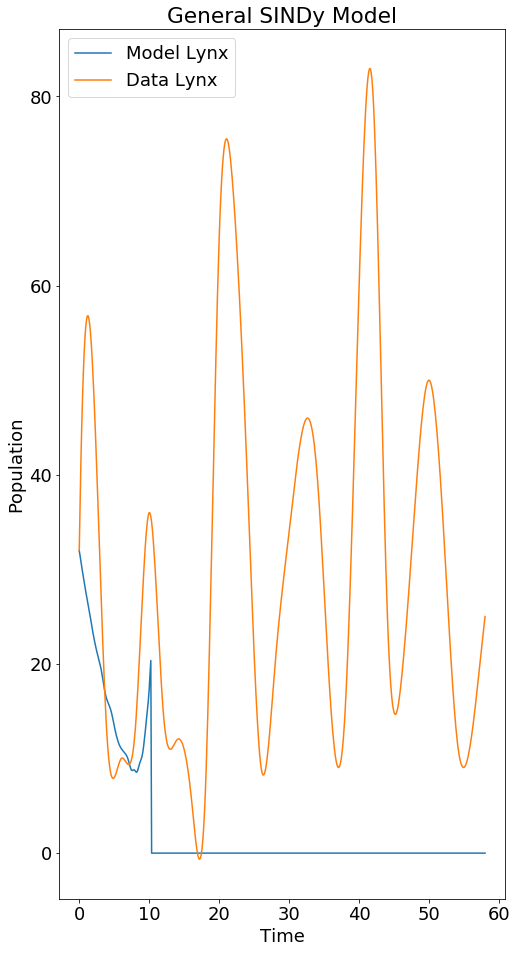

In [53]:
plt.plot(time_new, lynx_pop, label="Model Lynx")
plt.plot(time_new, lynx_interp, label="Data Lynx")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("General SINDy Model")
plt.legend()

## Compute Information Scores

In [17]:
# compute KL divergence for hares
hare_kl = KL_divergence(hare_interp,hare_pop)

# compute KL divergence for lynxes
lynx_kl = KL_divergence(lynx_interp,hare_pop)

print(hare_kl)

print(lynx_kl)

1.7909441534459676
1.8667105534422024


In [18]:
# compute aic score for hares
hare_aic = AIC(hare_interp,hare_pop,8)

# compute aic score for lynxes
lynx_aic = AIC(lynx_interp,lynx_pop,6)

print(hare_aic)
print(lynx_aic)

9181.981559028573
9627.45343815197


In [19]:
# compute bic score for hares
hare_bic = BIC(hare_interp,hare_pop,8)

# compute bic score for lynxes
lynx_bic = BIC(lynx_interp,lynx_pop,6)

print(hare_bic)
print(lynx_bic)

9215.69842381595
9652.741086742502
